## Load Module

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as ly
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import shutil

## Parameters

In [2]:
# the lambda parameters to balance regression and gan phase. lambda mean the regresion influence on gan.
lambda_1 = 0
lambda_2 = 0.01

# Inputs:Global parameters 
batch_size = 10
img_dim = 1856
z_dim = 115
y_dim = 1

# Optimizer: whether use adam for parameters update , if flag is set false use tf.train.RMEPropOptimzer
is_adam = False
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
learning_rate_reg = 2e-4
# the upper bound and lower bound in critic
clamp_lower =-0.01
clamp_upper = 0.01


# Train : Prameters
max_iter_step = 10000
device = '/gpu:0'
data_format = 'NCHW'
channel = 1
# Updata Diters times for critic in one iter(unless i<25 or i %500==0, i is the iterstep)
c_iterv = 2
Diters = 5
Diters = int(((c_iterv+1)/c_iterv*Diters))

# directory to store log ,include loss  and grad_norm of generator and critic
rgan_dir = './rgan_5'
log_dir = rgan_dir + '/log_rgan'
ckpt_dir = rgan_dir + '/ckpt_rgan'
spec_dir = rgan_dir + '/spec_rgan'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
else:
    shutil.rmtree(ckpt_dir)
    os.makedirs(ckpt_dir)
    
if not os.path.exists(spec_dir):
    os.makedirs(spec_dir)
else:
    shutil.rmtree(spec_dir)
    os.makedirs(spec_dir)

# write the hyperparameter to file
config_file = open(rgan_dir+'/config.txt','w')
config_file.write('IMPROVED RGAN:\n ,lambda_1: %s\n, lambda_2:%s' % (lambda_1,lambda_2))
config_file.close()

## Generator

In [3]:
def generator_conv(z):
    train = ly.fully_connected(z, 512*116, activation_fn = tf.nn.relu, normalizer_fn=None)
    train = tf.reshape(train,(-1,512,116,1))
    train = ly.conv2d_transpose(train, 256, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 128, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 64, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, channel , kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.tanh, padding='SAME',
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    return train

## Discriminator

In [4]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope('lrelu'):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x + f2*abs(x)

In [5]:
def critic_conv(x,reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        size = 64
        
        img = ly.conv2d(x,num_outputs=size,kernel_size=[3,1],stride=[2,1],padding='SAME',
                       activation_fn = lrelu,data_format=data_format,
                       weights_initializer = tf.random_normal_initializer(0,0.02))
        img = ly.conv2d(img,num_outputs= size*2,kernel_size=[3,1],stride=1,padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        img = ly.conv2d(img,num_outputs= size*4,kernel_size=[3,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        img = ly.conv2d(img,num_outputs= size*8,kernel_size=[3,1],stride=1,padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        img = tf.reshape(img,[batch_size,-1])
        # fully_connected
        disc = ly.fully_connected(img,1,activation_fn=None)
    
    return disc

## Regressor

In [6]:
def regression_conv(x,reuse=False):
    with tf.variable_scope('regressor') as scope:
        if reuse:
            scope.reuse_variables()
        size = 64
        img = ly.conv2d(x, num_outputs=size,kernel_size=(5,1),stride=1,padding='SAME',
                        data_format=data_format,activation_fn = tf.nn.relu)
        img = ly.max_pool2d(img, kernel_size=(4,1),stride=(2,1),padding='SAME',data_format = data_format)
        img = ly.conv2d(img,num_outputs = size*2,kernel_size=(5,1),stride=1,padding='SAME',
                       data_format = data_format,activation_fn = tf.nn.relu,normalizer_fn= ly.batch_norm,
                       normalizer_params={'fused':True,'data_format':data_format})
        img = ly.max_pool2d(img,kernel_size=(4,1),stride=(2,1),padding='SAME',data_format=data_format)
        
        img = tf.reshape(img,[batch_size,-1])
        
        # fully connett
        img = ly.fully_connected(img,128,activation_fn= tf.nn.relu,normalizer_fn=ly.batch_norm,
                                normalizer_params={'fused':True,'data_format':data_format})
        regr = ly.fully_connected(img,1,activation_fn=tf.nn.sigmoid)
    
    return regr    

## Build Graph & Loss Function

In [7]:
def build_graph(is_test=False):
    ##########################  Inputs ######################################
    # real data 
    real_data = tf.placeholder(dtype = tf.float32,shape=[batch_size,channel,img_dim,1])
    real_label = tf.placeholder(dtype = tf.float32,shape =[batch_size,y_dim])
    
    # Noise
    z_reg = tf.placeholder(dtype = tf.float32,shape =[batch_size,y_dim])
    z_rand = tf.placeholder(dtype =tf.float32,shape =[batch_size,z_dim])
    z = tf.concat([z_reg,z_rand],axis=1)
    #########################  End Inputs #####################################
    
    ##########################  Graph   ######################################
    generator = generator_conv
    discriminator = critic_conv
    regressor = regression_conv
    
    with tf.variable_scope('generator'):
        gen = generator(z)
    
    disc_real = discriminator(real_data)
    disc_fake = discriminator(gen, reuse=True)
    regr_real = regressor(real_data)
    regr_fake = regressor(gen, reuse=True)
    
    
    # Wasserstein distance
    d_loss = tf.reduce_mean(disc_fake - disc_real)
    g_loss = tf.reduce_mean( - disc_fake)
    g_loss_summ = tf.summary.scalar('wasserstein_loss_g' , g_loss)
    d_loss_summ = tf.summary.scalar('wasserstein_loss_d' , -d_loss)
    
    # Regression loss- mean- squared-error
    r_loss_f = tf.reduce_mean(tf.square(regr_fake-z_reg))
    r_loss_r = tf.reduce_mean(tf.square(regr_real-real_label))
    r_loss = (r_loss_f + r_loss_r)/2
    r_loss_f_summ = tf.summary.scalar('regression_f_loss',r_loss_f)
    r_loss_r_summ = tf.summary.scalar('regression_r_loss',r_loss_r)
    r_loss_summ = tf.summary.scalar('regression_loss',r_loss)
    
    # Loss of Discriminator and Generator, Discriminator train on True and False data
    loss_gen = (1-lambda_1)* g_loss + lambda_1 * r_loss_f
    loss_dis = d_loss
    loss_reg = (1-lambda_2)* r_loss_r + lambda_2 * r_loss_f
    loss_gen_summ = tf.summary.scalar('generator_loss',loss_gen)
    loss_dis_summ = tf.summary.scalar('discriminator_loss',loss_dis)
    loss_reg_summ = tf.summary.scalar('regressor_loss',loss_reg)
    ########################### End Graph   ######################################
    if is_test:
        return gen,regr_real,z_reg,z_rand,real_data
    
    ##################### Optimization ########################################
    # Variable Collection
    theta_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
    theta_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='discriminator')
    theta_r = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='regressor')
    
    # Optimizers
    counter_g = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_g = optimize(loss = loss_gen,variables=theta_g, learning_rate = learning_rate_gen,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_g,summaries=['gradient_norm','gradients'])
    
    counter_d = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_d = optimize(loss =loss_dis,variables=theta_d ,learning_rate = learning_rate_dis,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_d,summaries=['gradient_norm','gradients'])
    
    counter_r = tf.Variable(trainable=False, initial_value=0,dtype=tf.int32)
    opt_r = optimize(loss = loss_reg ,variables = theta_r,learning_rate = learning_rate_reg,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_r,summaries=['gradient_norm','gradients'])
    
    # Clip weights
    clipped_var_d = [tf.assign(var,tf.clip_by_value(var,clamp_lower,clamp_upper)) for var in theta_d]
    with tf.control_dependencies([opt_d]):
        opt_d = tf.tuple(clipped_var_d)
    ################################# End Optimization ################################################
    return opt_d, opt_g,opt_r ,real_data,real_label,z_reg,z_rand,loss_dis,loss_gen,loss_reg,gen

##  Optimizer

In [8]:
def optimize(loss,learning_rate, optimizer,variables,global_step,summaries):
    optim = optimizer(learning_rate=learning_rate)
    
    # Caculate gradients
    gradients = optim.compute_gradients(loss,var_list = variables)
    
    # Add summary
    if summaries is None:
        summaries = ['loss','learning_rate']
    if 'gradient_norm'  in summaries:
        tf.summary.scalar('global_norm/gradient_norm',tf.global_norm(list(zip(*gradients))[0]))
        
    if 'loss' in summaries:
        tf.summary.scalar('loss',loss)
    
    for gradient,variable in gradients:
        if isinstance(gradient,tf.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        
        if grad_values is not None:
            var_name = variable.name.replace(':','_')
            if 'gradients' in summaries:
                tf.summary.histogram('gradients/%s'%var_name, grad_values)
            
            if 'gradient_norm' in summaries:
                tf.summary.scalar('gradient_norm/%s'%var_name,tf.global_norm([grad_values]))
    return optim.apply_gradients(gradients,global_step=global_step)
        

## Plot

In [9]:
def save_spectrum(gen, i,is_show=False):
    # control the spect limitation and intv determine the the distance of spectrums
    intv = 0
    scale = 0.08
    # extend along y axis to visulize the difference between spetrum
    if is_show:
        extd = np.matlib.repmat(np.arange(0,batch_size),img_dim,1) 
        extd = extd * scale*intv
    else:
        extd = np.zeros((img_dim, batch_size))
    # convert data to ideal format    
    spec = gen.reshape(batch_size,img_dim)*(xmax-xmin)+ xmin
    spec = spec.transpose() + extd
    
    # plot the spectrum with ylimit legend and other thing
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(spec.shape[0]),spec ,'-*')
    if is_show:
        if intv ==0:
            plt.ylim([0,scale])
        else:
            plt.ylim([0,scale*batch_size*intv])
    else:
        plt.ylim([0,scale])
    
    plt.legend([np.array_str(var) for var in np.arange(batch_size)])
    
    if is_show:
        return plt.show()
    # savefig
    plt.savefig(spec_dir+'/'+str(i).zfill(4)+'.png')
    plt.close('all')

## Training Phase

Load dataset

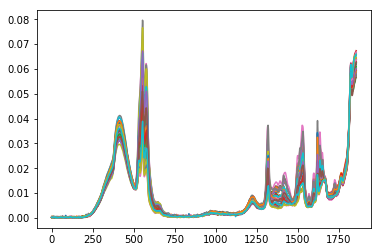

In [10]:
# from database load the data and label,clip the length network required
spect = scio.loadmat('ndata.mat')
x,y = spect['orgin'].transpose(),spect['result'][:,1]
if x.shape[1]>img_dim:
    x = x[:,:img_dim]
# plot raw data    
plt.plot(x.transpose(),'*-')
plt.show()
# pre_processing by minmaxmap
xmin, xmax, ymin, ymax = x.min(),x.max(), y.min(),y.max()
x,y = (x - xmin)/( xmax - xmin ),(y - ymin)/( ymax - ymin )

# reshape the data to the format that look like image
x= x.reshape(-1,1,img_dim,1)

In [11]:
def main():
    with tf.device(device):
        opt_d, opt_g,opt_r ,real_data,real_label,z_reg,z_rand,loss_dis,loss_gen,loss_reg,gen = build_graph()
    
    merged_all = tf.summary.merge_all()
    saver = tf.train.Saver()
    
    # config for Session and allow soft_placement
    config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
    config.gpu_options.allow_growth =True
    config.gpu_options.per_process_gpu_memory_fraction=0.9
    
    def next_feed_dict(iter,shuffled=True):
        # True data
        if shuffled:
            idx = np.random.randint(x.shape[0],size=(batch_size,))
            
        train_img,train_label = x[idx],y[idx].reshape(batch_size,1)
        
        #False data
        batch_z_rand = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
        # Gererate random labels as conditions , [0,1] gausson distribution
        if iter %2 ==0:
            y_generated = np.random.uniform(0,1,[batch_size,y_dim])
        else:
            y_generated = np.matlib.repmat(np.random.uniform(0,1),batch_size,y_dim)
            
        feed_dict = {real_data:train_img, real_label:train_label, z_rand:batch_z_rand, z_reg:y_generated}
        
        return feed_dict
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        summary_writer = tf.summary.FileWriter(log_dir,sess.graph)
        
        # training loop
        for i in range(max_iter_step+1):
            if i % 100 ==0:
                print(i)
            if i < 25 or i % 500 ==0:
                diters = 100
            else:
                diters = Diters*2
                
            #  Train Discriminator
            for j in range(diters):
                feed_dict = next_feed_dict(i)
                if i % 100  ==0 and j ==0:
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.NO_TRACE)
                    run_metadata = tf.RunMetadata()

                    _,loss_of_dis,merged = sess.run([opt_d,loss_dis,merged_all],feed_dict =feed_dict,
                                                          run_metadata=run_metadata,options =run_options)
                    print('the loss of discriminator is %0.3f '% -loss_of_dis)

                    summary_writer.add_summary(merged,i)
                    summary_writer.add_run_metadata(run_metadata,'discriminator_metedata{}'.format(i),i)
                else:
                    sess.run(opt_d,feed_dict =feed_dict,options =run_options)
            
            # Train Generator
            feed_dict = next_feed_dict(i)
            if i %100 ==0:
                _,loss_of_gen,spec,merged = sess.run([opt_g,loss_gen,gen,merged_all],feed_dict =feed_dict,
                                                 run_metadata=run_metadata,options = run_options)
                
                save_spectrum(spec,i)
                print('the loss of generator is %0.3f'%loss_of_gen)
                summary_writer.add_summary(merged, i)
                summary_writer.add_run_metadata(run_metadata,'generator_metadata{}'.format(i),i)
            else:
                sess.run(opt_g,feed_dict=feed_dict)
            
            # Train Regessor
            feed_dict = next_feed_dict(i)
            if i %100 ==0:
                _,loss_of_reg,merged = sess.run([opt_r,loss_reg,merged_all],feed_dict =feed_dict,
                                                 run_metadata=run_metadata,options = run_options)
                
                save_spectrum(spec,i)
                print('the loss of regressor is %0.3f'%loss_of_reg)
                summary_writer.add_summary(merged, i)
                summary_writer.add_run_metadata(run_metadata,'regressor_metadata{}'.format(i),i)
            else:
                sess.run(opt_g,feed_dict=feed_dict)
          
            # Save Model
            if i % 1000 ==0:
                saver.save(sess, os.path.join(ckpt_dir,'model_checkpoint'),global_step=i)
                

##  Testing Phase

In [12]:
def test(ckpt_dir=ckpt_dir):
    
    with tf.Session(config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
        # build graph
        with tf.device(device):
            gen,regr_real,z_reg,z_rand,real_data = build_graph(is_test=True)
        
        
        # use saver to reload the parametes
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(ckpt_dir))
        
        
        ###########################################  Experiment : Generator #################
        # Gererate random labels as conditions , [0,1] gausson distribution
        batch_z_rand = np.random.normal(0,1,[batch_size,z_dim]).astype(np.float32)
        y_generated = np.linspace(0,1,batch_size).reshape(batch_size,1)
        
        test_gen = sess.run(gen,feed_dict={z_rand:batch_z_rand,z_reg:y_generated}) 
        
        # Visualize the result
        save_spectrum(test_gen,_,is_show=True)
        
        ###########################################  Experiment : Regression #################        
        idx = 30
        test_img,test_label = x[idx:],y[idx:]
        
        pred_label = sess.run(regr_real,feed_dict ={real_data:test_img})
        
        print('the r2 score is %0.3f'%r2_score(pred_label,test_label))
        # plot Correlation coefficient diagram
        plt.plot(np.arange(len(test_label)),test_label,'r-',
                 np.arange(len(test_label)),pred_label,'b--')
        plt.show()
            

In [13]:
if __name__ =='__main__':
    tf.reset_default_graph()
    main()

0
the loss of discriminator is -0.196 
the loss of generator is 304.428
the loss of regressor is 0.163
100
the loss of discriminator is 399.660 
the loss of generator is 657.848
the loss of regressor is 0.161
200
the loss of discriminator is 1233.995 
the loss of generator is 561.422
the loss of regressor is 0.074
300
the loss of discriminator is 1129.953 
the loss of generator is -150.624
the loss of regressor is 0.072
400
the loss of discriminator is 212.898 
the loss of generator is -368.614
the loss of regressor is 0.133
500
the loss of discriminator is 446.166 
the loss of generator is 211.887
the loss of regressor is 0.136
600
the loss of discriminator is 214.625 
the loss of generator is -516.370
the loss of regressor is 0.030
700
the loss of discriminator is 30.952 
the loss of generator is 329.772
the loss of regressor is 0.010
800
the loss of discriminator is 554.797 
the loss of generator is -412.111
the loss of regressor is 0.042
900
the loss of discriminator is 414.343 
th

INFO:tensorflow:Restoring parameters from ./rgan_5/ckpt_rgan\model_checkpoint-10000


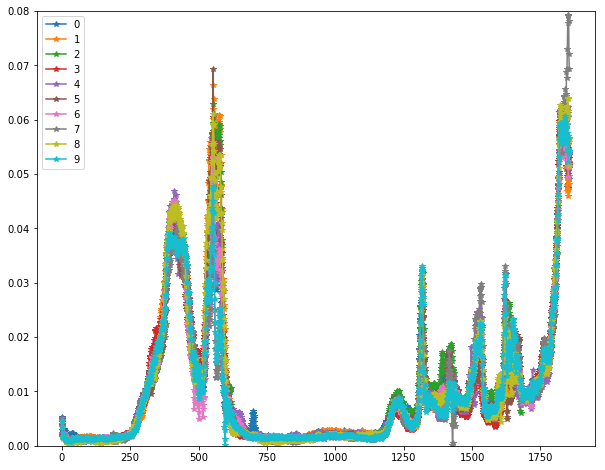

the r2 score is 0.721


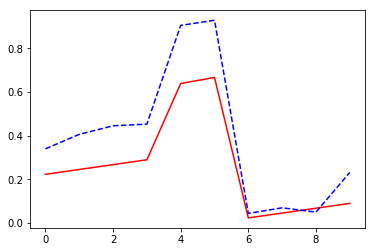

In [14]:
tf.reset_default_graph()
test(ckpt_dir)